# Klasyfikacja pasażerów Titanica - Rozwiązanie

Zadanie polega na stworzeniu modelu przewidującego szanse przeżycia katastrofy Titanica.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Wczytywanie danych
titanic_df = pd.read_csv('titanic.csv')

In [30]:
# Pierwsze spojrzenie na dane
print("Kształt datasetu:", titanic_df.shape)
print("\nPierwsze 5 wierszy:")
titanic_df.head()

Kształt datasetu: (891, 12)

Pierwsze 5 wierszy:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
# Podstawowe informacje o danych
print("Informacje o kolumnach:")
titanic_df.info()
print("\nBrakujące wartości:")
titanic_df.isnull().sum()

Informacje o kolumnach:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         793 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Brakujące wartości:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare            98
Cabin          687
Embarked         2
dtype: int64

## Eksploracyjna analiza danych

Sprawdzimy podstawowe statystyki i zależności w danych.

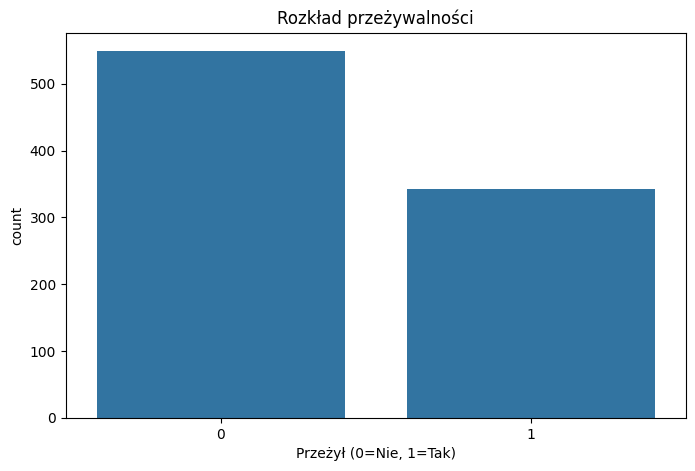

Procent osób które przeżyły: 38.38%


In [32]:

plt.figure(figsize=(8, 5))
sns.countplot(data=titanic_df, x='Survived')
plt.title('Rozkład przeżywalności')
plt.xlabel('Przeżył (0=Nie, 1=Tak)')
plt.show()

print(f"Procent osób które przeżyły: {titanic_df['Survived'].mean():.2%}")

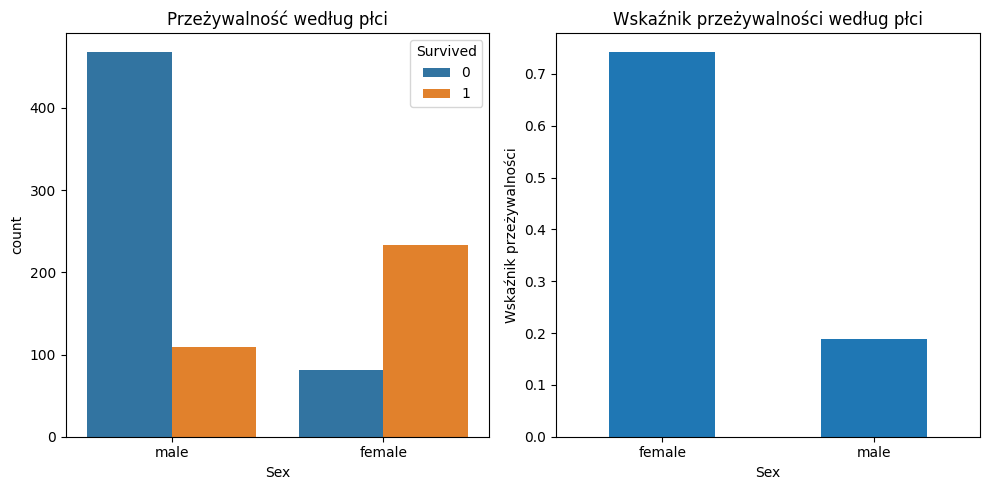

Przeżywalność według płci:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [33]:
# Przeżywalność według płci
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=titanic_df, x='Sex', hue='Survived')
plt.title('Przeżywalność według płci')

plt.subplot(1, 2, 2)
survival_by_sex = titanic_df.groupby('Sex')['Survived'].mean()
survival_by_sex.plot(kind='bar')
plt.title('Wskaźnik przeżywalności według płci')
plt.ylabel('Wskaźnik przeżywalności')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Przeżywalność według płci:")
print(survival_by_sex)

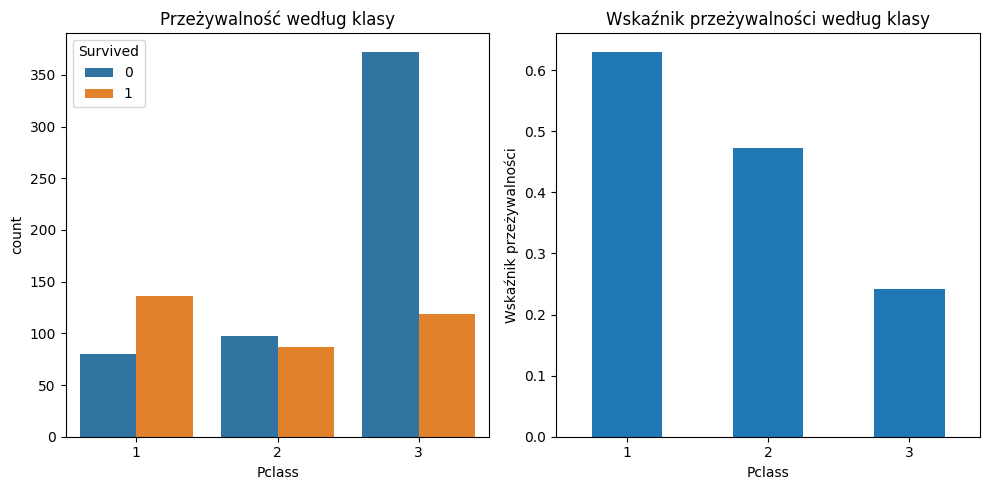

Przeżywalność według klasy:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


In [34]:
# Przeżywalność według klasy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=titanic_df, x='Pclass', hue='Survived')
plt.title('Przeżywalność według klasy')

plt.subplot(1, 2, 2)
survival_by_class = titanic_df.groupby('Pclass')['Survived'].mean()
survival_by_class.plot(kind='bar')
plt.title('Wskaźnik przeżywalności według klasy')
plt.ylabel('Wskaźnik przeżywalności')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Przeżywalność według klasy:")
print(survival_by_class)

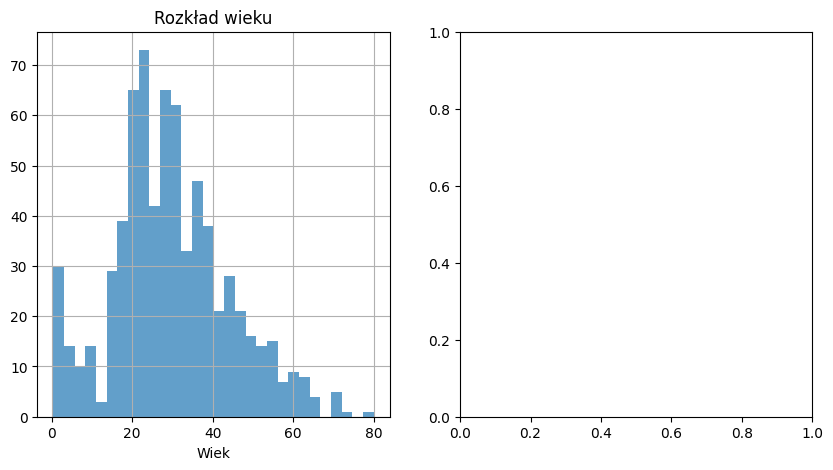

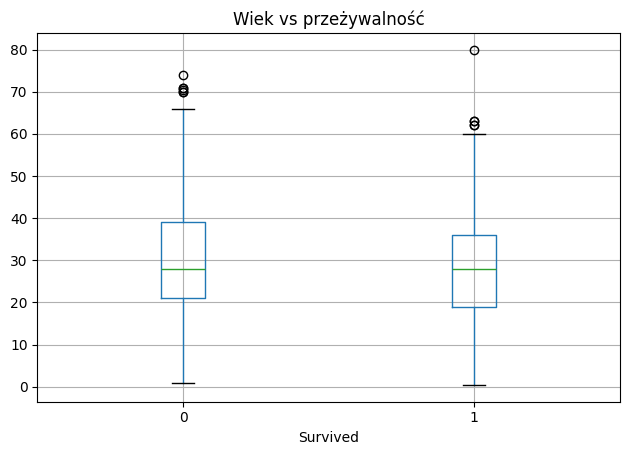

In [35]:
# Rozkład wieku
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
titanic_df['Age'].hist(bins=30, alpha=0.7)
plt.title('Rozkład wieku')
plt.xlabel('Wiek')

plt.subplot(1, 2, 2)
titanic_df.boxplot(column='Age', by='Survived')
plt.title('Wiek vs przeżywalność')
plt.suptitle('')
plt.tight_layout()
plt.show()

## Przygotowanie danych do modelowania

Zauważono, że trzeba oczyścić dane i przygotować je do trenowania modelu.

In [36]:

df = titanic_df.copy()

# Uzupełniamy wiek medianą
df['Age'].fillna(df['Age'].median(), inplace=True)

df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Uzupełniamy Embarked najczęstszą wartością
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Usuwamy Cabin
df.drop('Cabin', axis=1, inplace=True)

# nowe cechy
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Kodowanie kategorycznych
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

print("Dane po przygotowaniu:")
print(df.info())
print("\nBrakujące wartości:")
print(df.isnull().sum())

Dane po przygotowaniu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    int64  
 11  FamilySize   891 non-null    int64  
 12  IsAlone      891 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 90.6+ KB
None

Brakujące wartości:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0


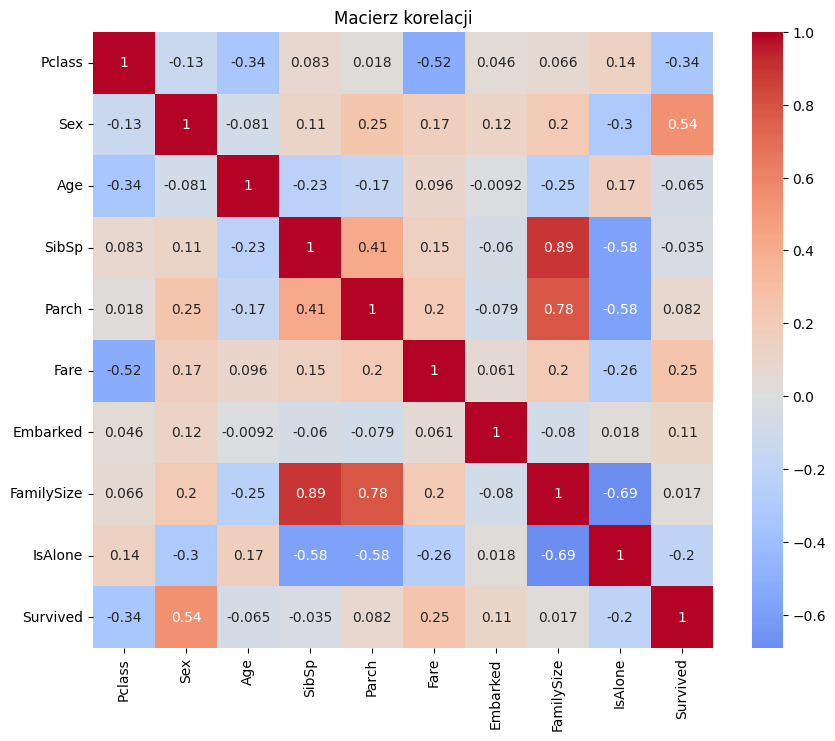

In [37]:
# Sprawdzamy korelacje
plt.figure(figsize=(10, 8))
correlation_matrix = df[features + ['Survived']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Macierz korelacji')
plt.show()

## Trenowanie modeli

Przetestujemy dwa modele: Random Forest i Regresję Logistyczną.

In [38]:
# Podział na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Rozmiar zbioru treningowego: {X_train.shape}")
print(f"Rozmiar zbioru testowego: {X_test.shape}")

Rozmiar zbioru treningowego: (712, 9)
Rozmiar zbioru testowego: (179, 9)


In [39]:
# Model 1: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predykcje
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Random Forest - Dokładność: {rf_accuracy:.4f}")
print("\nRaport klasyfikacji:")
print(classification_report(y_test, rf_pred))

Random Forest - Dokładność: 0.8045

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [40]:
# Model 2: Regresja Logistyczna
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predykcje
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"Regresja Logistyczna - Dokładność: {lr_accuracy:.4f}")
print("\nRaport klasyfikacji:")
print(classification_report(y_test, lr_pred))

Regresja Logistyczna - Dokładność: 0.8045

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



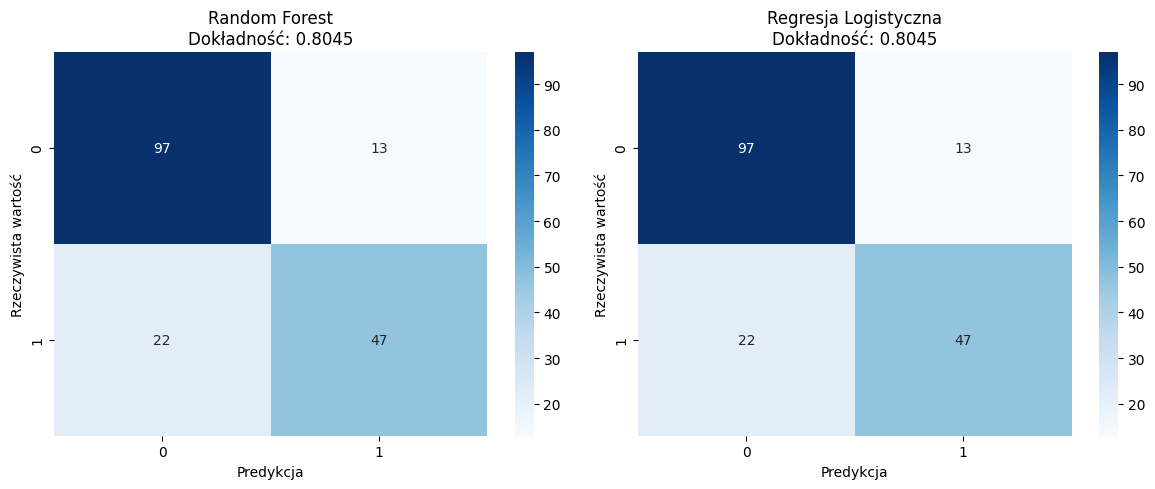

In [41]:
# Macierze pomyłek
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Random Forest\nDokładność: {rf_accuracy:.4f}')
plt.ylabel('Rzeczywista wartość')
plt.xlabel('Predykcja')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Regresja Logistyczna\nDokładność: {lr_accuracy:.4f}')
plt.ylabel('Rzeczywista wartość')
plt.xlabel('Predykcja')

plt.tight_layout()
plt.show()

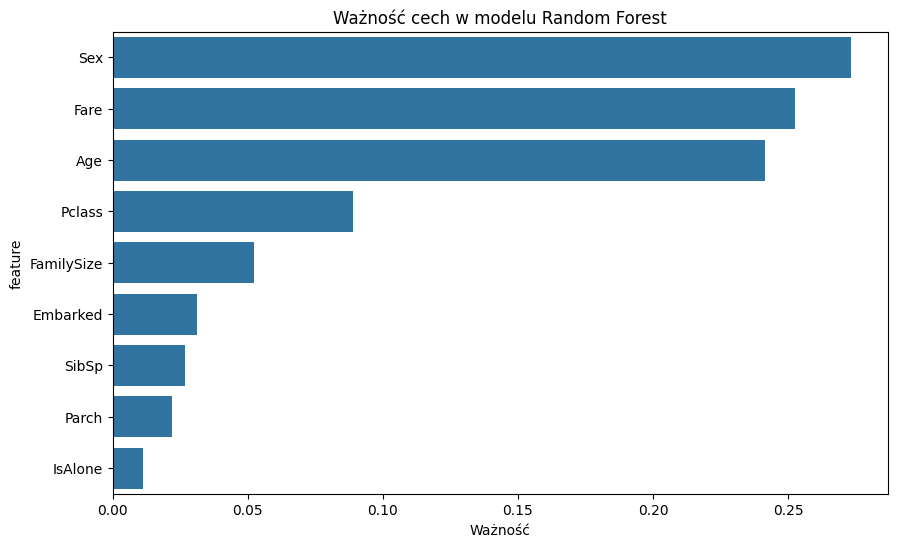

Ranking ważności cech:
      feature  importance
1         Sex    0.273222
5        Fare    0.252486
2         Age    0.241505
0      Pclass    0.089082
7  FamilySize    0.052311
6    Embarked    0.031386
3       SibSp    0.026788
4       Parch    0.021851
8     IsAlone    0.011370


In [42]:
# Ważność cech w Random Forest
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Ważność cech w modelu Random Forest')
plt.xlabel('Ważność')
plt.show()

print("Ranking ważności cech:")
print(feature_importance)

## Wnioski

Na podstawie analizy zauważono:

1. **Płeć była kluczowym czynnikiem** - kobiety miały znacznie wyższe szanse przeżycia
2. **Klasa podróży miała duże znaczenie** - pasażerowie pierwszej klasy przeżywali częściej
3. **Wiek odgrywał rolę** - dzieci miały lepsze szanse
4. **Rozmiar rodziny** również wpływał na przeżywalność

Oba modele osiągnęły podobną dokładność, ale Random Forest może lepiej uchwycić nieliniowe zależności.

In [43]:
# Przykładowe predykcje dla nowych pasażerów
print("Przykładowe predykcje:")
print("\n1. Mężczyzna, 3 klasa, 25 lat, bez rodziny:")
example1 = [[3, 0, 25, 0, 0, 7.25, 0, 1, 1]]
pred1 = rf_model.predict_proba(example1)[0]
print(f"   Prawdopodobieństwo przeżycia: {pred1[1]:.2%}")

print("\n2. Kobieta, 1 klasa, 30 lat, z rodziną:")
example2 = [[1, 1, 30, 1, 1, 80, 1, 3, 0]]
pred2 = rf_model.predict_proba(example2)[0]
print(f"   Prawdopodobieństwo przeżycia: {pred2[1]:.2%}")

print("\n3. Dziecko, 2 klasa, 5 lat:")
example3 = [[2, 1, 5, 1, 1, 20, 0, 3, 0]]
pred3 = rf_model.predict_proba(example3)[0]
print(f"   Prawdopodobieństwo przeżycia: {pred3[1]:.2%}")

Przykładowe predykcje:

1. Mężczyzna, 3 klasa, 25 lat, bez rodziny:
   Prawdopodobieństwo przeżycia: 4.00%

2. Kobieta, 1 klasa, 30 lat, z rodziną:
   Prawdopodobieństwo przeżycia: 99.00%

3. Dziecko, 2 klasa, 5 lat:
   Prawdopodobieństwo przeżycia: 79.00%
